In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [6]:
program = factories.Program.factory('2019-01-24', version='1.0')

In [7]:
program.predict(dataset_params = {
    'from': '2018-12-01',
    'to': '2018-12-10'
}, locked=True)

preparing model data
preparing stacked model data


In [8]:
len(program.df)

5694

In [9]:
df = program.df

In [28]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                nth = (r['final_odds_ref']<odds).sum()+1
                
                #bet = np.clip(np.abs(player[target])/100.0, 0, 10)
                
                #bet = np.round(1+bet) * 1.5
                
                #if bet <= 0:
                #    break
                
                if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                    NN = NN+1
                    
                bet = 1
                
                wd = player['final_odds_ref_unibet'] if player['final_odds_ref_unibet'] > player['final_odds_ref'] else player['winner_dividend']

                profit = wd/100.0 * bet - bet
                profit_placed = player['placed_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds_ref_unibet'], player['final_odds'], target, player[target], r[target].std(), bet, profit, profit_placed]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])
                    

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_unibet', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit', 'profit_placed']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])
    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [27]:
#exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'pred_stacked'] + ['pred_stacked_{}'.format(pos+1) for pos in range(1,8)] + ['pred_xgb_100_1', 'pred_rf_100_1', 'pred_knn_5_1', 'pred_mlp_100_1', 'pred_ridge_1_1']).sort_values(by='pred_stacked_8', ascending=False)
exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_unibet', 'target_pos', 'pred_xgb_100_1'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]).sort_values(by='position', ascending=True)



position  declared_player_count sub_category  num  final_odds  \
race_id                                                                      
52996   455       1.0                     11    AUTOSTART   10        13.7   
        452       2.0                     11    AUTOSTART    7         3.0   
        451       3.0                     11    AUTOSTART    6        79.3   
        453       4.0                     11    AUTOSTART    8        26.9   
        456       5.0                     11    AUTOSTART   11        29.2   
        447       6.0                     11    AUTOSTART    2        81.6   
        454       7.0                     11    AUTOSTART    9        83.2   
        449       8.0                     11    AUTOSTART    4         2.6   
        448       9.0                     11    AUTOSTART    3         5.2   
        450      10.0                     11    AUTOSTART    5        11.8   
        446       NaN                     11    AUTOSTART    1         1.5   

             final_odds_unibet  target_pos  pred_xgb_100_1  pred_xgb_10_1  \
race_id                                                                     
52996   455               19.8           0        0.112295       0.130408   
        452                2.8           0        0.156340       0.141711   
        451               42.4           0        0.093804       0.127808   
        453               19.3           0        0.108361       0.116812   
        456               45.3           0        0.120429       0.116812   
        447               37.5           0        0.098492       0.114237   
        454               76.2           0        0.095572       0.116812   
        449                2.2           0        0.138468       0.135265   
        448                7.0           0        0.106076       0.135265   
        450               11.7           0        0.106101       0.114237   
        446                NaN           0        0.068755       0.133349   

             pred_xgb_30_1  pred_xgb_100_1  pred_knn_1_1  pred_knn_2_1  \
race_id                                                                  
52996   455       0.105519        0.112295      0.333333      0.166667   
        452       0.150699        0.156340      0.333333      0.166667   
        451       0.103890        0.093804      0.000000      0.166667   
        453       0.101308        0.108361      0.000000      0.166667   
        456       0.102376        0.120429      0.000000      0.166667   
        447       0.106649        0.098492      0.000000      0.000000   
        454       0.090607        0.095572      0.333333      0.333333   
        449       0.125472        0.138468      0.333333      0.166667   
        448       0.113685        0.106076      0.000000      0.166667   
        450       0.104895        0.106101      0.333333      0.166667   
        446       0.098890        0.068755      0.333333      0.166667   

             pred_knn_3_1  pred_knn_4_1  pred_knn_5_1  pred_knn_6_1  \
race_id                                                               
52996   455      0.111111      0.083333      0.066667      0.111111   
        452      0.111111      0.166667      0.133333      0.166667   
        451      0.111111      0.166667      0.133333      0.166667   
        453      0.222222      0.166667      0.133333      0.111111   
        456      0.111111      0.166667      0.133333      0.111111   
        447      0.111111      0.166667      0.200000      0.166667   
        454      0.222222      0.166667      0.133333      0.111111   
        449      0.222222      0.250000      0.200000      0.166667   
        448      0.111111      0.083333      0.066667      0.111111   
        450      0.222222      0.166667      0.200000      0.166667   
        446      0.111111      0.083333      0.066667      0.055556   

             pred_knn_7_1  pred_knn_8_1  pred_knn_9_1  pred_knn_10_1  \
race_id                              

In [31]:
df = program.df
df['pred_rnd'] = np.random.rand(df.shape[0])
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)

#for model in program.model.models:
#    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)
#    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)


for model in program.model.models:
    df['pred_minus_ref_{}'.format(model['name'])] = df['pred_{}_1'.format(model['name'])] - df['final_odds_ref']
    
for model in program.model.stacked_models:
    df['pred_minus_ref_stacked_{}'.format(model['name'])] = df['pred_stacked_{}_1'.format(model['name'])] - df['final_odds_ref']



bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_{}'.format(model['name'], i+1) for i in range(program.model.params['n_targets']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] 
   )

'''
bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]
   )
'''
    
    

"\nbets = bet(df, program.model.features, program.model.categorical_features, \n    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, \n    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]\n   )\n"

In [ ]:
program.df.race_id.nunique()

In [32]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] != 0) & (bb['pred'] != 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'profit_place': bbb.profit_placed.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()    

    
    

In [ ]:
#countries = list(bets['country'].value_counts()[0:10].index)
#sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

#%store countries
#%store sub_categories

In [34]:
%store -r params
%store -r countries
%store -r sub_categories

In [35]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'final_odds_ref'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 30, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,3)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,3):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['target']==target) & (bets['pred_std'] >= 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    b = b[(b['pred'] > params['min_pred']) & (b['pred'] < params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,3):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [ ]:
#from skopt import dummy_minimize, gp_minimize, gbrt_minimize

#res = gbrt_minimize(f, space, n_calls=100)

In [ ]:
#print(res.x, res.fun)

In [ ]:
#params = x_to_params(res.x)
#%store params

In [ ]:
len(program.model.models[0]['estimators'])
program.model.hash

In [ ]:
bb = ff(params, False)

                                    avg  bet  bets  profit  profit_place
idx_1  idx_2                                                            
ATTELE pred_stacked_mlp_relu_1 -0.94025   12    12 -11.283          -7.5


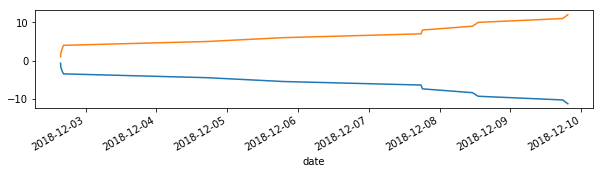

In [43]:
#bb = bets
bb = bets[ (bets['sub_category']=='AUTOSTART') & (bets['nb']==2) & (bets['target']=='pred_stacked_mlp_relu_1') & (bets['odds_ref']<8) & (bets['odds_ref']>3) & (bets['pred']<=1) ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & (bets['odds_ref']>=bets['odds_1']) & (bets['odds_ref']<20) & (bets['target']!='psred_mlp_20_1') ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']=='AUTOSTART') & (bets['nb']<=0) & (bets['odds_ref']>=0) & (bets['odds_ref']<20) ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & ( (bets['target']=='pred_knn_10_1') | (bets['target']=='pred_minus_ref_lasso_1') ) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>20)].copy()        
#bb = bets[ (bets['country']=='FRA') & (bets['nb']==0) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>0)].copy()
#bb = bb.groupby('id').filter(lambda r: r['num'].count() == 2)
#graph_bb( bets[(bets['target']=='pred_lasso_0.1_1') & (bets['nb']==0) & (bets['odds_ref']>5) & (bets['odds_ref']<20) & (bets['pred']>0.)], 'sub_category')
#bb['profit'] = bb['profit'] * 1/(1+bb['nb'])
#bb['bet'] = bb['bet'] * 1/(1+bb['nb'])

#bb['profit'] = bb['profit'] * np.round(bb['pred']*100)
#bb['bet'] = bb['bet'] * np.round(bb['pred']*100)

graph_bb(bb, 'category')




In [ ]:
len(df[ (df['position']==1)  ])

In [ ]:
df['placed_3_count'].describe()

In [ ]:
bb